# 16 Land cover statistics

## About the data

In this lesson we will use two datasets.

The first one is [GAP/LANDFIRE National Terrestrial Ecosystems data for 2011 @davidson_gaplandfire_2016](https://www.sciencebase.gov/catalog/item/573cc51be4b0dae0d5e4b0c5), from the [US Geological Survey (USGS)](https://www.usgs.gov). This is a categorical raster with a 30 m x 30 m pixel resolution representing highly thematically detailed land cover map of the U.S. We will access this data through the [Microsoft Planetary Computer (MPC) data catalog](https://planetarycomputer.microsoft.com/dataset/gap). The class names and corresponding codes have been saved to a separete CSV to simplify access in this lesson. Further information on how to access the classes directly from the data are available in the [MPC catalog](https://planetarycomputer.microsoft.com/dataset/gap#Example-Notebook).


The second dataset is a shapefile with the perimeters for 2017 California fires. This data was extracted from the CALFIRE's [Historical Wildland Fire Perimeters](https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all/about).

## Import auxiliary geometries

Let's start by importing the necessary libraries:

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd
import rioxarray as rioxr
from shapely import box

import pystac_client
import planetary_computer

from IPython.display import Image 

Then import and select the Thomas Fire within the fire perimeters data:

<Axes: >

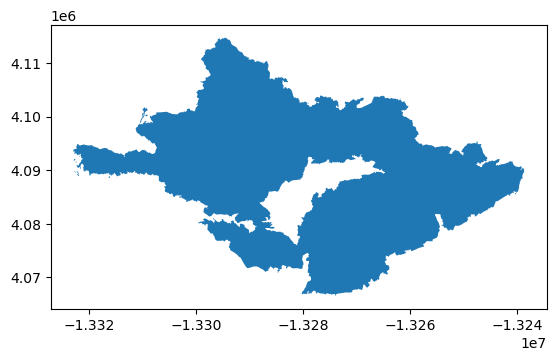

In [4]:
root = os.path.join('/','courses','EDS220','data')
fire_perimeters = gpd.read_file(os.path.join(root,
                  'California_Fire_Perimeters_2017',
                  'California_Fire_Perimeters_2017.shp'
                 ))
thomas_fire = fire_perimeters[fire_perimeters['FIRE_NAME']=='THOMAS']

# Examine fire perimeter data
thomas_fire.crs
thomas_fire.plot()

And import the CA state perimeter:

<Axes: >

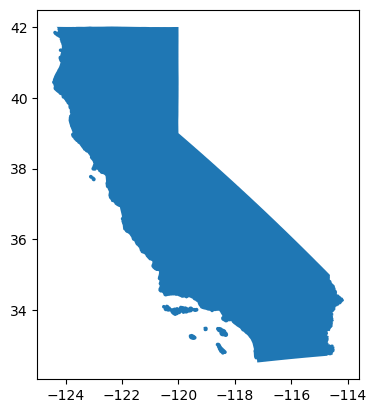

In [5]:
ca = gpd.read_file(os.path.join(root,
                                'ca_state_boundary',   
                                'ca_state_boundary.shp'))
ca.plot()

## Catalog search

Our goal is to retrieve the National Terrestrial Ecosystems data over the fire perimeter. In the [last lesson](/book/chapters/lesson-16-STAC.qmd) we used GeoJSON-type dictionary to do the catalog search. Here we will use a list `[xmin, ymin, xmax, ymax]` with the coordinate values defining the four corners of the region we want to search data over. Just as the GeoJSON, these coordinates have to be in the EPSG:4326 CRS. 

Our bounding box will come from the Thomas Fire perimeter. Notice we use method chaining to reproject and extract the bounds.

In [7]:
# Create bounding box for search
thomas_fire_bbox = list(thomas_fire.to_crs('epsg:4326') # Reproject for search
                                   .total_bounds)
thomas_fire_bbox

[-119.68162520650904,
 34.279899796001956,
 -118.92518097019486,
 34.63745683414112]

Next, we connect to the Microsoft Planetary Computer data catalog and perform the search. The collection ID for the National Terrestrial Ecosystems data is `gap`:

In [8]:
# Open MPC data catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)


In [9]:
# Search MPC catalog
search = catalog.search(collections=['gap'],
                       bbox=thomas_fire_bbox)

In [10]:
# Retrieve search items
items = search.item_collection()
print(f"Returned{len(items)} Items")
items

Returned1 Items


There is a single item in the search, so let's go ahead and select it and view its pre-rendered image: 

In [11]:
# Select unique search item
item = items[0]

# Display pre-rendered image
Image(url=item.assets['rendered_preview'].href, width=600)

To interperate the map, import the CSV file with the class labels:

In [17]:
labels = pd.read_csv(os.path.join(root,
                                 'GAP_National_Terrestrial_Ecosystems.csv'))
labels.head()

,class_label,code
0,0,0
1,South Florida Bayhead Swamp,1
2,South Florida Cypress Dome,2
3,South Florida Dwarf Cypress Savanna,3
4,South Florida Mangrove Swamp,4


In metadata, 0 is used as the no-data value for this raster. This will be relevant in a moment. 

## Explore Raster

Next, we can go ahead and open the raster:

In [18]:
# Access raster data from item
lulc = rioxr.open_rasterio(item.assets['data'].href)
lulc

<xarray.DataArray (band: 1, y: 10000, x: 10000)> Size: 200MB
[100000000 values with dtype=uint16]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 80kB -2.361e+06 -2.361e+06 ... -2.061e+06
  * y            (y) float64 80kB 1.762e+06 1.762e+06 ... 1.462e+06 1.462e+06
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_SOFTWARE:        ERDAS IMAGINE
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  2 (pixels/inch)
    AREA_OR_POINT:           Area
    scale_factor:            1.0
    add_offset:              0.0

Notice that `band` is a dimension of length 1. We can go ahead and "squeeze" the raster to simplify it

In [19]:
# Remove length 1 dimension (band)
lulc = lulc.squeeze().drop_vars('band')
print("Size of dimensions:", dict(lulc.sizes))

Size of dimensions: {'y': 10000, 'x': 10000}


Next, let's look at how the raster is located with repect to the Thomas Fire perimeter and the CA state boundary:

In [20]:
# Create GeoDataFrame from raster bounding box
lulc_bbox = gpd.GeoDataFrame(geometry = [box(*lulc.rio.bounds())],
                            crs = lulc.rio.crs)


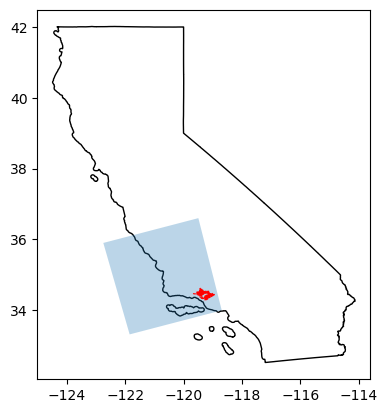

In [21]:
# Plot raster boundary, fire perimeter, and CA boundary 
fig, ax = plt.subplots()
ca.plot(ax=ax, color='white', edgecolor='black')

# Reproject lulc_bbox and fire perimeter to match CA crs
lulc_bbox.to_crs(ca.crs).plot(ax=ax, alpha=0.3)
thomas_fire.to_crs(ca.crs).plot(ax=ax, color='red')

plt.show()

The raster covers a big area relative to the fire perimeter. Since we want to calculate the land coverage statistics within the fire perimeter, we will have to clip the raster to this area. 

## Clip raster to geometry

In our first lesson about rasters, we saw how to clip a raster to a rectangular region. In our case, we want to clip the raster exactly to the fire perimeter. Clipping can be a costly operation for such a big raster relative to a detailed geometry. So we will perform the clipping in two steps:

1. Clip the raster using the fire perimeter bounding box using `rio.clip_box()` and then 
2. Clip the simplified raster to the fire perimeter using `rio.clip()`

In [22]:
# Match CRSs and verify update 
thomas_fire_match = thomas_fire.to_crs(lulc.rio.crs)
assert thomas_fire_match.crs == lulc.rio.crs

In [24]:
# Clip large raster to detailed geometry in two steps
lulc_step1 = lulc.rio.clip_box(*thomas_fire_match.total_bounds)

In [25]:
lulc_step2 = lulc_step1.rio.clip(thomas_fire_match.geometry) #Produces RuntimeWarning

/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:215: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


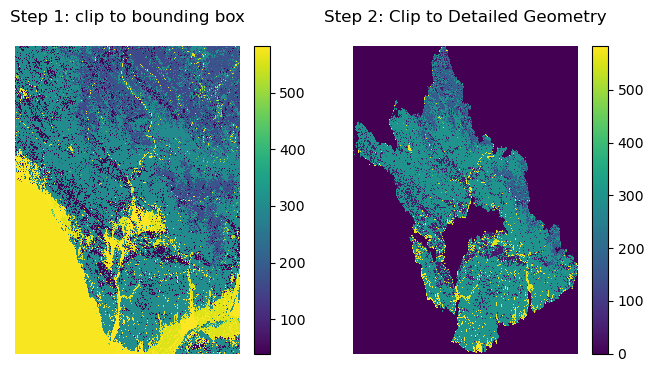

In [26]:
# plot raster
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# Plot the first clipped raster
lulc_step1.plot(ax=ax[0])
ax[0].set_title("Step 1: clip to bounding box")
ax[0].axis('off')

# Plot the second clipped raster
lulc_step2.plot(ax=ax[1])
ax[1].set_title("Step 2: Clip to Detailed Geometry")
ax[1].axis("off")

plt.show()

## Raster no-data values

Notice a warning appeared when we clipped the raster. After some investigation, we will find that this `RuntimeWarning` occurs becasue the `rio.clip()` function tries to replace values outside the fire-perimeter geometry with np.nan. However, as we previously saw, our raster's data type is `uint16` (16 bits unsigned integer). The cast issue appears since `np.nan` is a `float` and it cannot be casted as a `uint16`. To make sure the clipping operator fills in any pixels with the adequate no-data value, let's manually set it: 

In [28]:
print('Original no-data value:', lulc.rio.nodata)

# Update raster's no-data value
lulc = lulc.rio.write_nodata(0)
print('Original no-data value:', lulc.rio.nodata)


Original no-data value: None
Original no-data value: 0


This way, the rio.clip() function will know what values to assign to pixels outside the fire perimeter. lets try clipping again, this time using method chaining: 

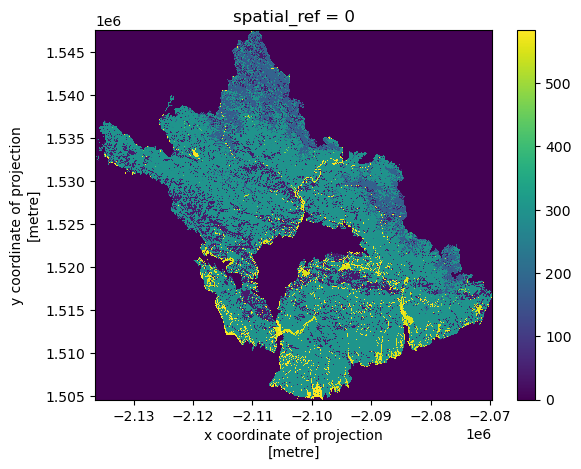

In [29]:
# Clip extent using method chaining
lulc_clip = (lulc.rio.clip_box(*thomas_fire_match.total_bounds)
            .rio.clip(thomas_fire_match.geometry))

# Examine results
lulc_clip.plot()

# Land cover statistics


In [37]:
# 1. Get the number of pixels per class
value, counts = np.unique(lulc_clip, return_counts=True)
assert len(value) == len(counts)

In [38]:
# 2. Initialize dictionary with column's data
dic = {'code': value,
       'counts': counts}
# Create a data frame 
pix_counts = pd.DataFrame(dic)
pix_counts.head()

,code,counts
0,0,1927850
1,39,6856
2,40,361
3,41,133707
4,42,3639


In [48]:
#3. Use labels data frame to add class names
classes = pix_counts.merge(labels, on = 'code', how='left')
classes

,code,counts,class_label
0,0,1927850,0
1,39,6856,California Central Valley Mixed Oak Savanna
2,40,361,California Coastal Closed-Cone Conifer Forest ...
3,41,133707,California Coastal Live Oak Woodland and Savanna
4,42,3639,California Lower Montane Blue Oak-Foothill Pin...
5,43,23148,Central and Southern California Mixed Evergree...
6,45,2907,Southern California Oak Woodland and Savanna
7,55,4974,Mediterranean California Mixed Evergreen Forest
8,159,3727,California Montane Jeffrey Pine-(Ponderosa Pin...
9,162,60203,Mediterranean California Dry-Mesic Mixed Conif...


5.What area within the fire perimeter in km^2 was estimated to be developed? 

- find indexes for developed class
`Developed, Open Space`, `Developed, Low Intensity`, `Developed, medium Intensity`, `Developed High Intensity`
- select class
- resolution of raster in km: 30x30m pixels
- calculate 
47,'counts'])} km^2.")


In [52]:
# 5.
area = classes.iloc[44:48].counts.sum() * 0.9
print(f"The developed area in the fire perimeter is {area} km^2.")

The developed area in the fire perimeter is 40795.200000000004 km^2.


In [76]:
# 6. Store the total number of pixels within the fire perimeter as a variable
# filter na-value
classes = classes[classes.code != 0]
total_pixels = sum(classes['counts'])
print(f"The total number of pixels within fire perimeter is {total_pixels}")



The total number of pixels within fire perimeter is 1267102


In [77]:
# 7. Add the percentage of area covered by each class as a new column
classes['percentage_cover'] = (classes.counts/total_pixels) * 100

# Sort the df in descending order
classes = classes.sort_values(by="percentage_cover", ascending=False)
classes.head()

,code,counts,class_label,percentage_cover
19,303,454498,Southern California Coastal Scrub,35.869093
18,302,183963,Southern California Dry-Mesic Chaparral,14.518405
3,41,133707,California Coastal Live Oak Woodland and Savanna,10.552189
20,304,88503,California Central Valley and Southern Coastal...,6.984678
11,183,75924,Great Basin Pinyon-Juniper Woodland,5.991941


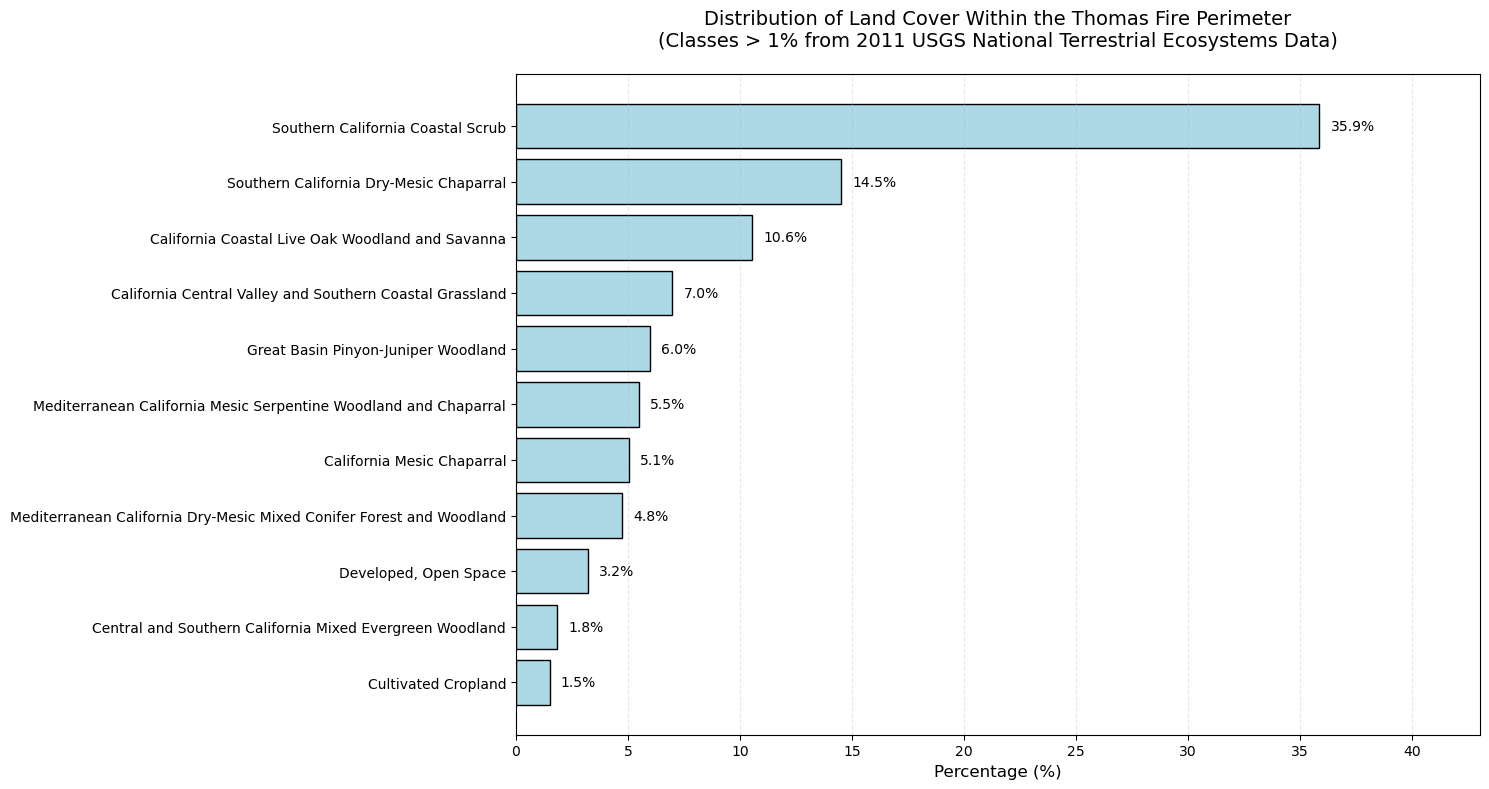

In [79]:
# 8. Create a horizontal bar plot showing the classes more than 1% land cover

# Select classes that has significant cover
# and Sort values in descending order
plot_data = classes[classes['percentage_cover'] >= 1].sort_values('percentage_cover', ascending=True)

# Create figure and axis with specified size
plt.figure(figsize=(15, 8))

# Create horizontal bar plot
bars = plt.barh(range(len(plot_data)), plot_data['percentage_cover'], 
                color='lightblue', edgecolor='black')

# Customize the plot
plt.title('Distribution of Land Cover Within the Thomas Fire Perimeter\n(Classes > 1% from 2011 USGS National Terrestrial Ecosystems Data)',
          pad=20, fontsize=14)

# Add value labels at the end of each bar
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width+0.5, bar.get_y() + bar.get_height()/2,
             f'{width:.1f}%', 
             ha='left', va='center', fontsize=10)


# Customize axes
plt.xlabel('Percentage (%)', fontsize=12)
plt.grid(True, axis='x', linestyle='--', alpha=0.3)

# Set y-axis labels using the class names
plt.yticks(range(len(plot_data)), plot_data.class_label, fontsize=10)

# Adjust layout and margins
plt.margins(x=0.2)  # Add some space on the right for percentage labels
plt.tight_layout()

# Show the plot
plt.show()